In [1]:
!pip install pytesseract

In [2]:
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
import pytesseract as pt
import plotly.express as px
import matplotlib.pyplot as plt
import xml.etree.ElementTree as xet

from glob import glob
from skimage import io
from shutil import copy
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import TensorBoard
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
!unzip /content/drive/MyDrive/Copyofarchive2.zip

Archive:  /content/drive/MyDrive/Copyofarchive2.zip
replace annotations/Cars0.xml? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

InceptionResNetV2

In [6]:
inception_resnet = InceptionResNetV2(weights="imagenet",include_top=False, input_tensor=Input(shape=(224,224,3)))

headmodel = inception_resnet.output
headmodel = Flatten()(headmodel)
headmodel = Dense(32, activation="relu")(headmodel)
headmodel = Dropout(0.3)(headmodel)
headmodel = Dense(32, activation="relu")(headmodel)
headmodel = Dense(4, activation='sigmoid')(headmodel)

model = Model(inputs=inception_resnet.input,outputs=headmodel)

In [7]:
path = glob('/content/annotations/*.xml')
labels_dict = dict(filepath=[],xmin=[],xmax=[],ymin=[],ymax=[])
for filename in path:

    info = xet.parse(filename)
    root = info.getroot()
    member_object = root.find('object')
    labels_info = member_object.find('bndbox')
    xmin = int(labels_info.find('xmin').text)
    xmax = int(labels_info.find('xmax').text)
    ymin = int(labels_info.find('ymin').text)
    ymax = int(labels_info.find('ymax').text)

    labels_dict['filepath'].append(filename)
    labels_dict['xmin'].append(xmin)
    labels_dict['xmax'].append(xmax)
    labels_dict['ymin'].append(ymin)
    labels_dict['ymax'].append(ymax)

In [8]:
df = pd.DataFrame(labels_dict)
df.to_csv('labels.csv',index=False)

In [9]:
def getFilename(filename):
    filename_image = xet.parse(filename).getroot().find('filename').text
    filepath_image = os.path.join('/content/images',filename_image)
    return filepath_image

In [10]:
image_path = list(df['filepath'].apply(getFilename))

In [11]:
labels = df.iloc[:, 1:].values

data = []
output = []

for img_path, label in zip(image_path, labels):

    img_arr = cv2.imread(img_path)
    h, w, d = img_arr.shape


    img_resized = load_img(img_path, target_size=(224, 224))
    img_array = img_to_array(img_resized) / 255.0

    xmin, xmax, ymin, ymax = label
    normalized_bbox = (
        xmin / w, xmax / w, ymin / h, ymax / h
    )

    data.append(img_array)
    output.append(normalized_bbox)

data = np.array(data)
output = np.array(output)


In [12]:
X = np.array(data,dtype=np.float32)
y = np.array(output,dtype=np.float32)

In [13]:
x_train,x_test,y_train,y_test = train_test_split(X,y,train_size=0.8,random_state=42)

In [14]:
model.compile(loss='mse',optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 111, 111, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 111, 111, 32)   │             96 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 111, 111, 32)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 109, 109, 32)   │          9,216 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 109, 109, 32)   │             96 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 109, 109, 32)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 109, 109, 64)   │         18,432 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 109, 109, 64)   │            192 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 109, 109, 64)   │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 54, 54, 64)     │              0 │ activation_2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 54, 54, 80)     │          5,120 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 54, 54, 80)     │            240 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 54, 54, 80)     │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 52, 52, 192)    │        138,240 │ activation_3[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 52, 52, 192)    │            576 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_4 (Activat

 Total params: 55,566,756 (211.97 MB)

 Trainable params: 55,506,212 (211.74 MB)

 Non-trainable params: 60,544 (236.50 KB)

In [15]:
tfb = TensorBoard('object_detection')
history = model.fit(x=x_train,y=y_train,batch_size=10,epochs=10,
                    validation_data=(x_test,y_test),callbacks=[tfb])

Epoch 1/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 277s 3s/step - loss: 0.0826 - val_loss: 0.1725
Epoch 2/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 17s 228ms/step - loss: 0.0475 - val_loss: 0.0965
Epoch 3/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 10s 233ms/step - loss: 0.0431 - val_loss: 0.0814
Epoch 4/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 227ms/step - loss: 0.0377 - val_loss: 0.1061
Epoch 5/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 10s 222ms/step - loss: 0.0348 - val_loss: 0.0446
Epoch 6/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 10s 221ms/step - loss: 0.0173 - val_loss: 0.0260
Epoch 7/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 10s 227ms/step - loss: 0.0184 - val_loss: 0.0423
Epoch 8/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 10s 219ms/step - loss: 0.0200 - val_loss: 0.0384
Epoch 9/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 10s 220ms/step - loss: 0.0153 - val_loss: 0.0347
Epoch 10/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 10s 224ms/step - loss: 0.0131 - val_loss: 0.0296


In [16]:
model.save('./model.keras')

In [17]:
new_model = tf.keras.models.load_model('/content/model.keras')

Now, to read the image car license plate try multiple images

In [18]:
path = '/content/images/Cars1.png'
def object_detection(path):

    # Read image
    image = load_img(path) # PIL object
    image = np.array(image,dtype=np.uint8) # 8 bit array (0,255)
    image1 = load_img(path,target_size=(224,224))

    # Data preprocessing
    image_arr_224 = img_to_array(image1)/255.0 # Convert to array & normalized
    h,w,d = image.shape
    test_arr = image_arr_224.reshape(1,224,224,3)

    # Make predictions
    coords = new_model.predict(test_arr)
    # Denormalize the values
    denorm = np.array([w,w,h,h])
    coords = coords * denorm
    coords = coords.astype(np.int32)
    xmin, xmax,ymin,ymax = coords[0]
    pt1 =(xmin,ymin)
    pt2 =(xmax,ymax)
    print(pt1, pt2)
    cv2.rectangle(image,pt1,pt2,(0,255,0),3)
    return image, coords

image, cods = object_detection(path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step
(146, 131) (247, 161)


In [24]:
img = np.array(load_img(path))
xmin ,xmax,ymin,ymax = cods[0]
roi = img[ymin:ymax,xmin:xmax]
fig = px.imshow(roi)
fig.update_layout(width=350, height=250, margin=dict(l=10, r=10, b=10, t=10),xaxis_title='Figure 15 Cropped image')

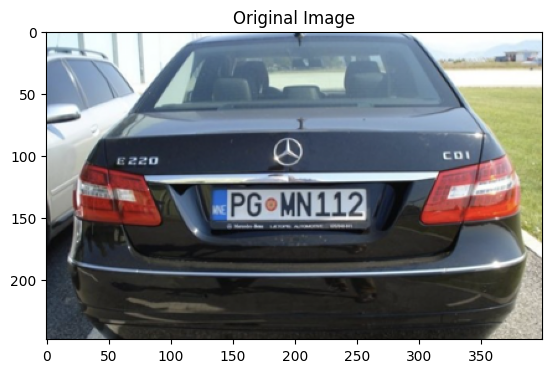

Text(0.5, 1.0, 'Processed Image')

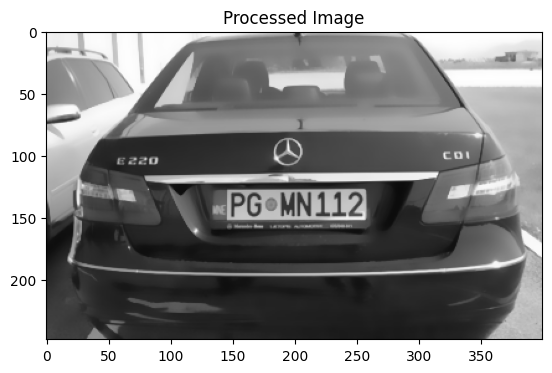

In [25]:
img = cv2.imread('/content/images/Cars1.png') #read image
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.show()

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) #convert image to gray
bfilter = cv2.bilateralFilter(gray, 11, 17, 17) #Noise reduction
plt.imshow(cv2.cvtColor(bfilter, cv2.COLOR_BGR2RGB)) #show processed image
plt.title('Processed Image')

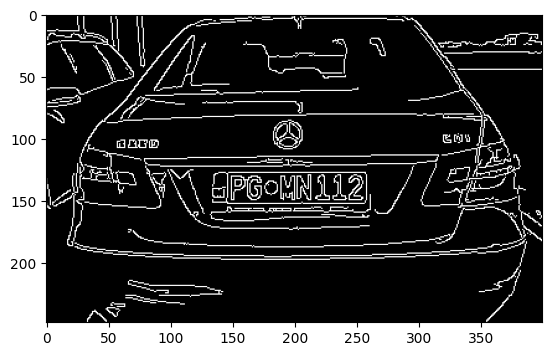

In [26]:
edged = cv2.Canny(bfilter, 30, 200)
plt.imshow(cv2.cvtColor(edged, cv2.COLOR_BGR2RGB))

In [27]:
!pip install imutils

In [28]:
import imutils

In [29]:
keypoints = cv2.findContours(edged.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
contours = imutils.grab_contours(keypoints)
contours = sorted(contours, key=cv2.contourArea, reverse=True)[:10]

In [30]:
location = None
for contour in contours:
    approx = cv2.approxPolyDP(contour, 10, True)
    if len(approx) == 4:
        location = approx
        break

print("Location: ", location)

Location:  [[[146 128]]

 [[256 127]]

 [[258 149]]

 [[147 152]]]


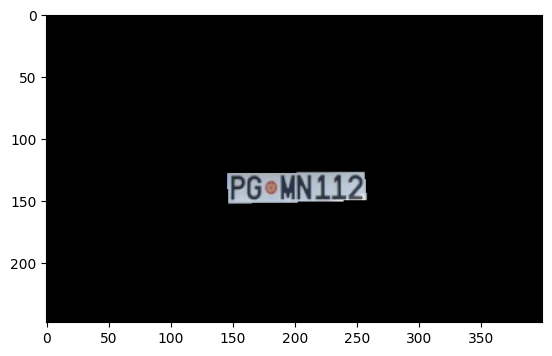

In [31]:
mask = np.zeros(gray.shape, np.uint8)
new_image = cv2.drawContours(mask, [location], 0,255, -1)
new_image = cv2.bitwise_and(img, img, mask=mask)

plt.imshow(cv2.cvtColor(new_image, cv2.COLOR_BGR2RGB))

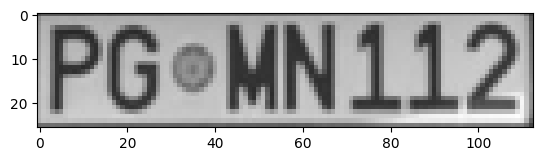

In [33]:
(x,y) = np.where(mask==255)
(x1, y1) = (np.min(x), np.min(y))
(x2, y2) = (np.max(x), np.max(y))
cropped_image = gray[x1:x2+1, y1:y2+1]

plt.imshow(cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB))

In [34]:
!sudo apt update
!sudo apt install -y tesseract-ocr

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:4 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:5 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,172 kB]
Get:7 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:8 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:10 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [8,506 kB]
Get:11 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 Packages [1,512 kB]
Hit:12 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:13 http://security.ubuntu.com/ubun

In [35]:
!tesseract --version

tesseract 4.1.1
 leptonica-1.82.0
  libgif 5.1.9 : libjpeg 8d (libjpeg-turbo 2.1.1) : libpng 1.6.37 : libtiff 4.3.0 : zlib 1.2.11 : libwebp 1.2.2 : libopenjp2 2.4.0
 Found AVX512BW
 Found AVX512F
 Found AVX2
 Found AVX
 Found FMA
 Found SSE
 Found libarchive 3.6.0 zlib/1.2.11 liblzma/5.2.5 bz2lib/1.0.8 liblz4/1.9.3 libzstd/1.4.8


In [36]:
import pytesseract

In [40]:
roi = cropped_image

In [41]:
text = pt.image_to_string(roi)
print(text)

 

PGeMN112

